In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))\

import numpy as np
import pandas as pd
import GPy
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError:
    pass
    
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
    
%matplotlib inline

In [2]:
df=pd.read_csv('bitcoin_start-240418.csv')

In [3]:
df=df[:-2]
df["Dataindex"] = df.index                        ## Keep index, could be usefull
df.index=df.Date    
df.index=df.index.to_datetime()
df=df.drop(columns=['Date'])

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning:to_datetime is deprecated. Use pd.to_datetime(...)


In [4]:
print('lowest price' ,min(df['Close Price']))
print('Highest price',max(df['Close Price']))

lowest price 0.05
Highest price 19343.04


Text(0,0.5,'Price ($)')

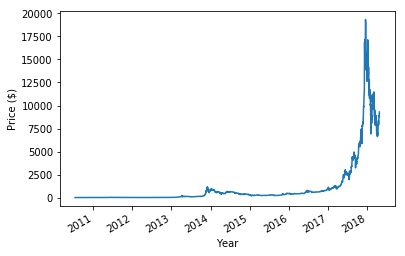

In [5]:
df['Close Price'].plot()
plt.xlabel('Year')
plt.ylabel('Price ($)')

In [6]:
#take log scale
df['Close Price']=np.log(df['Close Price'])

Text(0,0.5,'Price ($)')

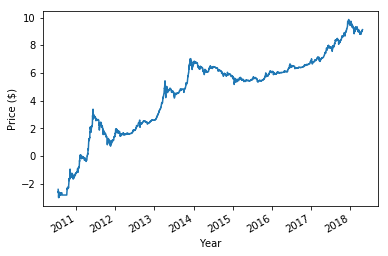

In [7]:
df['Close Price'].plot()#df['Close Price'][-250:].plot()
plt.xlabel('Year')
plt.ylabel('Price ($)')

In [8]:
week_avg=df.groupby([df.index.weekday]).mean()

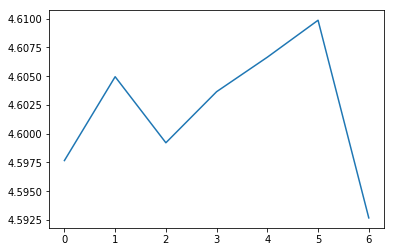

In [9]:
week_avg['Close Price'].plot()

### Data of one year

In [27]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"][-365:]).reshape(-1, 1)

X = np.array(df["Dataindex"][-365:]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

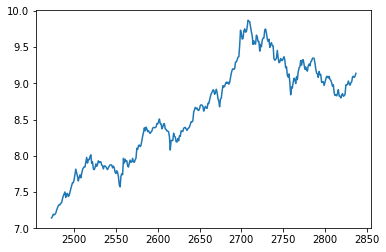

In [11]:
plt.plot(X,Y)

## NOTES

#### Possible problems
* GP Assumes that the observations come from Gaussian process, do we satisfy this?
    * * "The assumption that our observations came from a Gaussian process is a very strong assumption" https://blog.sigopt.com/posts/intuition-behind-gaussian-processes
* The toy dataset did not work, with periodic kernel :s

#### Approaches
* Data by weekday
* ~~Two dimensional. Weekday + weeknumber?~~
    * * Periodic kernel defined only for 1dim
    
    
#### Meeting with Michael
* Fourier transform
* log-transform data
* non-stationary kernels
* Brownian motion kernel
* Make some more complicated toy data with linear/RBF trend. Do experiments with data with and without periodicity. See if variance of periodic kernel is different
    *  goal is to show if modeling periodicity like this even makes sense

In [12]:
#Tinka's cool stuff
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=20)#when larger period, error: non-positive diagonal elements
PERIODIC3 = GPy.kern.PeriodicMatern52(input_dim=1,period=2)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1,period=7)
EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1)
LIN2 = GPy.kern.Linear(1,variances=3)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(1)

RBF_PER = LIN#+BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3



 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
linear.variances,1.0523827994731549e-05,+ve,
Gaussian_noise.variance,0.21481512099174227,+ve,


(array([[1.45981184]]), array([[0.21483683]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


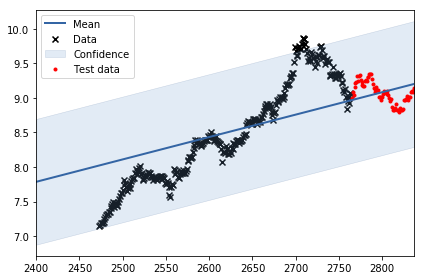

In [13]:
m = GPy.models.GPRegression(X_train, Y_train, LIN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
rbf.variance,33.58236504623726,+ve,
rbf.lengthscale,15.569851016098673,+ve,
Gaussian_noise.variance,0.0029948477902645453,+ve,


(array([[0.]]), array([[33.58535989]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


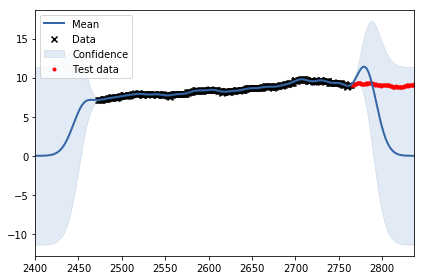

In [14]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.32292740526236,+ve,
sum.rbf.lengthscale,8.915310034974677,+ve,
sum.bias.variance,71.84334869936589,+ve,
Gaussian_noise.variance,0.0023995208642122725,+ve,


(array([[8.47136966]]), array([[0.3482788]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


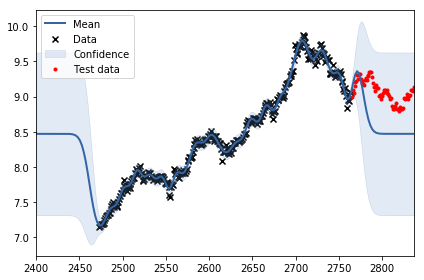

In [15]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.12831299086127423,+ve,
sum.rbf.lengthscale,4.937362387084613,+ve,
sum.linear.variances,1.0490418299258285e-05,+ve,
Gaussian_noise.variance,0.0014785792137246509,+ve,


(array([[1.45745777]]), array([[0.12994609]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


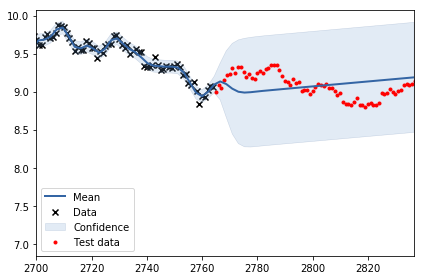

In [16]:
RBF_PER = RBF+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.xlim(2700,)
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.linear.variances,1.0523504315964627e-05,+ve,
sum.rbf.variance,33.58236461174034,+ve,
sum.rbf.lengthscale,15.569851025452504,+ve,
sum.periodic_Matern52.variance,0.9999999425785588,+ve,
sum.periodic_Matern52.lengthscale,1.0000000338160584,+ve,
sum.periodic_Matern52.period,6.999998816509253,+ve,
sum.periodic_Matern52_1.variance,0.9863717185178278,+ve,
sum.periodic_Matern52_1.lengthscale,1.051783163530469,+ve,
sum.periodic_Matern52_1.period,28.98804862165938,+ve,
Gaussian_noise.variance,0.9999998191433044,+ve,


(array([[0.51320657]]), array([[1114.68531863]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


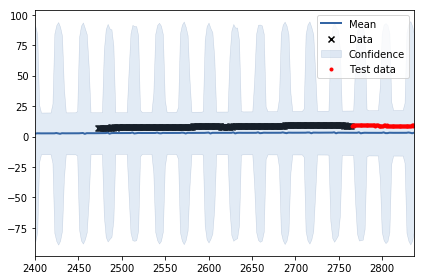

In [17]:
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=30)
#PERIODIC2.period.fix()
RBF_PER = LIN+RBF+PERIODIC+PERIODIC2
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
#plt.xlim(2700,)
#plt.ylim(8,12)
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


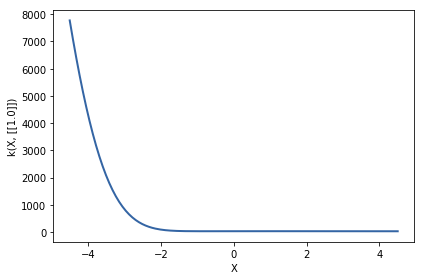

In [18]:
RBF_PER.plot()

GP_regression.,value,constraints,priors
sum.rbf.variance,0.710126912912852,+ve,
sum.rbf.lengthscale,8.262697976678915,+ve,
sum.linear.variances,1.1434417198289918e-05,+ve,
sum.periodic_Matern52.variance,0.003757391980190643,+ve,
sum.periodic_Matern52.lengthscale,9.552313500945157,+ve,
sum.periodic_Matern52.period,7.0,+ve fixed,
Gaussian_noise.variance,0.002565158360990232,+ve,


(array([[1.42173924]]), array([[0.00297522]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


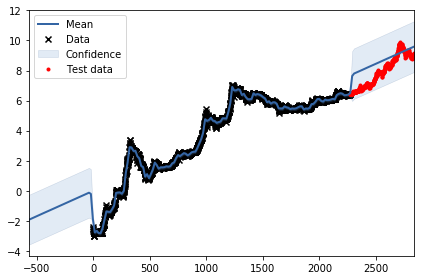

In [26]:
RBF_PER = RBF+LIN+PERIODIC
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.1283116985231861,+ve,
sum.rbf.lengthscale,4.9373512980494745,+ve,
sum.linear.variances,1.0490435494242411e-05,+ve,
sum.mul.periodic_Matern52.variance,4.4501380557091415e-07,+ve,
sum.mul.periodic_Matern52.lengthscale,27.69093956208384,+ve,
sum.mul.periodic_Matern52.period,1.2395144533672782,+ve,
sum.mul.RatQuad.variance,4.4501380557091415e-07,+ve,
sum.mul.RatQuad.lengthscale,6.440761072455145e-06,+ve,
sum.mul.RatQuad.power,7.426173246008715,+ve,
Gaussian_noise.variance,0.0014785794500621068,+ve,


(array([[1.45745778]]), array([[0.1299448]]))


 /home/tinka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


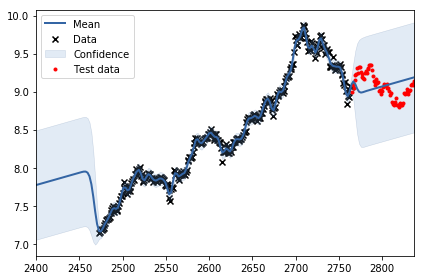

In [26]:
#WTF, why??? 
#Multiplying with RBF or RQ gives almost same as not including any periodicity at all.. 
RBF_PER = RBF+LIN+PERIODIC*LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.12831217883577095,+ve,
sum.rbf.lengthscale,4.937370982769672,+ve,
sum.linear.variances,1.0490958814777946e-05,+ve,
sum.periodic_Matern52.variance,2.358712266399814e-17,+ve,
sum.periodic_Matern52.lengthscale,61.18903990573627,+ve,
sum.periodic_Matern52.period,7.0,+ve fixed,
Gaussian_noise.variance,0.0014785825592670719,+ve,


(array([[1.45745778]]), array([[0.12994528]]))


 /home/tinka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


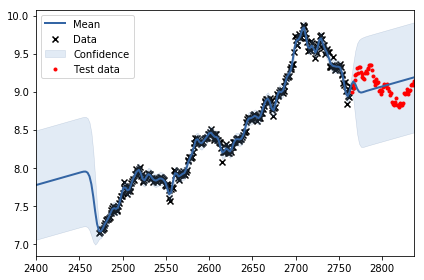

In [21]:
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2.period.fix()
RBF_PER = RBF+LIN+PERIODIC2
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()

plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.12831270156978555,+ve,
sum.rbf.lengthscale,4.937363525746875,+ve,
sum.linear.variances,1.049119910967683e-05,+ve,
sum.periodic_Matern52.variance,2.4891665414008742e-14,+ve,
sum.periodic_Matern52.lengthscale,47.24451660272142,+ve,
sum.periodic_Matern52.period,7.0,+ve fixed,
Gaussian_noise.variance,0.0014785758461418636,+ve,


(array([[1.45745778]]), array([[0.1299458]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


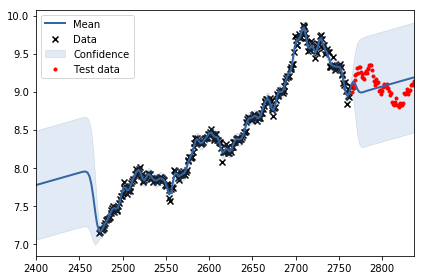

In [35]:
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2.period.fix()
RBF_PER = RBF+LIN+PERIODIC2
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:328: RuntimeWarning:invalid value encountered in add
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:310: RuntimeWarning:overflow encountered in true_divide
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in multiply
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in cos
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:328: RuntimeWarning:overflow encountered in true_divide
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/periodic.py:328: RuntimeWarning:overflow encountered in multiply


GP_regression.,value,constraints,priors
sum.rbf.variance,0.03583520084095178,+ve,
sum.rbf.lengthscale,3.8961730945477484,+ve,
sum.linear.variances,0.9719492713199094,+ve,
sum.periodic_Matern52.variance,0.8481245189108257,+ve,
sum.periodic_Matern52.lengthscale,1.3335619666871625,+ve,
sum.periodic_Matern52.period,6.020826344267054,+ve,
sum.periodic_Matern52_1.variance,0.8818057800122034,+ve,
sum.periodic_Matern52_1.lengthscale,1.1742662977328422,+ve,
sum.periodic_Matern52_1.period,7.0,+ve fixed,
sum.periodic_Matern52_2.variance,0.9798531329031404,+ve,


(array([[1.45544206]]), array([[0.03688167]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


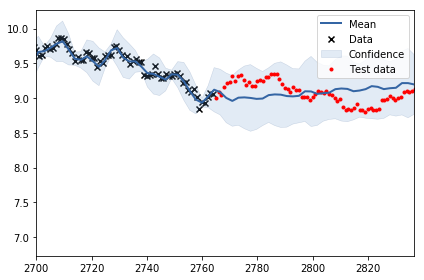

GP_regression.,value,constraints,priors
RatQuad.variance,71.93359507121978,+ve,
RatQuad.lengthscale,2.92294013522942,+ve,
RatQuad.power,0.00022041180423966792,+ve,
Gaussian_noise.variance,0.0010512010095864006,+ve,


(array([[8.33616919]]), array([[0.30407932]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


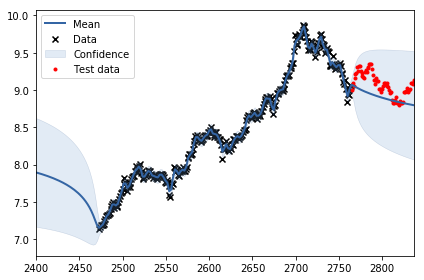

In [106]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.mul.rbf.variance,0.4195289715784449,+ve,
sum.mul.rbf.lengthscale,1.0473093374755467,+ve,
sum.mul.periodic_Matern52.variance,0.4195289715838445,+ve,
sum.mul.periodic_Matern52.lengthscale,4.5390601082817,+ve,
sum.mul.periodic_Matern52.period,7.0,+ve fixed,
sum.rbf.variance,0.7356901791911136,+ve,
sum.rbf.lengthscale,11.13725945551656,+ve,
sum.linear.variances,1.1420885721156189e-05,+ve,
Gaussian_noise.variance,6.573910160929628e-08,+ve,


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


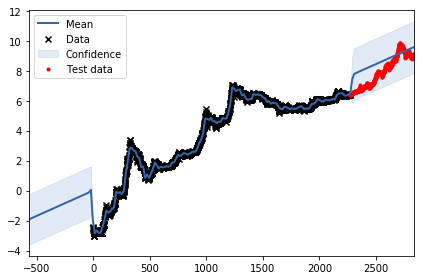

In [25]:
RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1, variance=2., lengthscale=5)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC.period.fix()
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=20)#when larger period, error: non-positive diagonal elements
PERIODIC3 = GPy.kern.PeriodicMatern52(input_dim=1,period=2)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1,period=7)
EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1)
LIN2 = GPy.kern.Linear(1,variances=3)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(1)

KERN = RBF*PERIODIC + RBF2 +LIN

m = GPy.models.GPRegression(X_train, Y_train, KERN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()


### All data, same tests as above

In [23]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"]).reshape(-1, 1)

X = np.array(df["Dataindex"]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

GP_regression.,value,constraints,priors
linear.variances,1.1503712117879787e-05,+ve,
Gaussian_noise.variance,1.4535497177257604,+ve,


(array([[1.52625687]]), array([[1.45362526]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


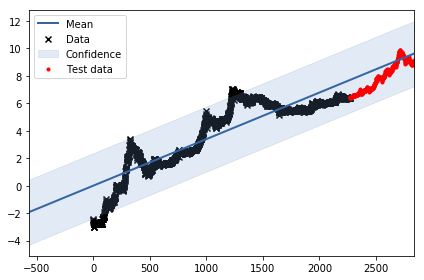

In [125]:
m = GPy.models.GPRegression(X_train, Y_train, LIN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
rbf.variance,8.818079163198147,+ve,
rbf.lengthscale,12.307683192555354,+ve,
Gaussian_noise.variance,0.003214822412012793,+ve,


(array([[1.41355232]]), array([[0.00360957]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


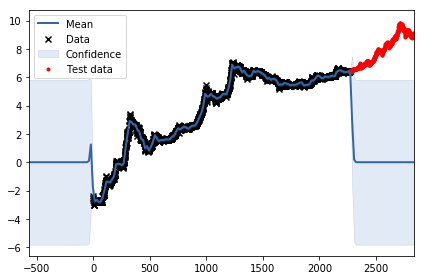

In [126]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,3.168631931364024,+ve,
sum.rbf.lengthscale,11.320228744862842,+ve,
sum.bias.variance,14.052587247939801,+ve,
Gaussian_noise.variance,0.0031279804921154255,+ve,


(array([[1.41633462]]), array([[0.00352489]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


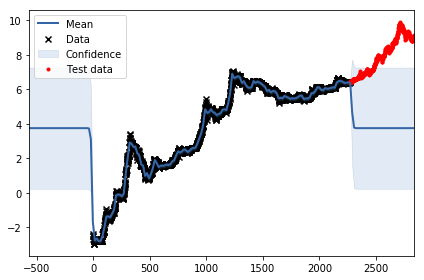

In [127]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.7101701006922922,+ve,
sum.rbf.lengthscale,8.269566062209925,+ve,
sum.linear.variances,1.1445005799209215e-05,+ve,
Gaussian_noise.variance,0.002571091441585328,+ve,


(array([[1.42209787]]), array([[0.00298035]]))


 /home/tinka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


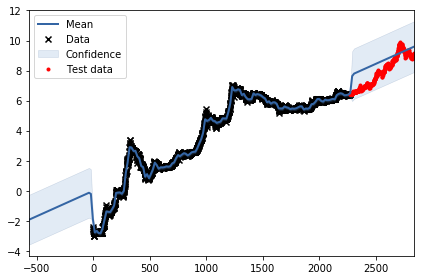

In [14]:
RBF_PER = RBF+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.6991483402202332,+ve,
sum.rbf.lengthscale,8.247215523598273,+ve,
sum.bias.variance,0.09521621954851328,+ve,
sum.linear.variances,1.2736635039382179e-05,+ve,
Gaussian_noise.variance,0.002567161592427858,+ve,


(array([[1.42203778]]), array([[0.0029765]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


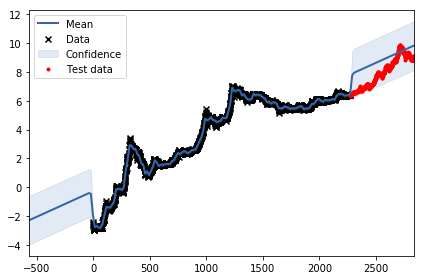

In [128]:
RBF_PER = RBF+BIAS+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
RatQuad.variance,59.058210755656255,+ve,
RatQuad.lengthscale,3.9166612378203958,+ve,
RatQuad.power,0.0006257672539028429,+ve,
Gaussian_noise.variance,0.0015444320614922632,+ve,


(array([[1.39877973]]), array([[0.00200046]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


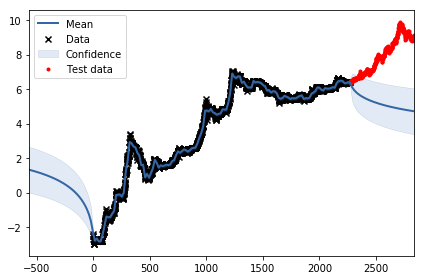

In [130]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))